In [1]:
import csv

import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32

In [47]:
dataset = rasterio.open("./data/crs.tiff")
img_data = dataset.read(1)
block_size = 30


def get_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_data, dataset)

In [48]:
with open('training/data_bin.csv', 'r') as f:
    reader = csv.DictReader(f)
    labeled_coords = [r for r in reader]
print("labeled dataset contains {} points".format(len(labeled_coords)))

labeled dataset contains 115 points


In [49]:
X = list(map(get_image, labeled_coords))
Y = [int(l['windmill']) for l in labeled_coords]

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [51]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
3/3 [==============================] - 0s 10ms/step - loss: 0.2460 - accuracy: 0.9000
Epoch 2/10
3/3 [==============================] - 0s 9ms/step - loss: 0.2100 - accuracy: 0.9125
Epoch 3/10
3/3 [==============================] - 0s 10ms/step - loss: 0.2341 - accuracy: 0.9125
Epoch 4/10
3/3 [==============================] - 0s 12ms/step - loss: 0.2196 - accuracy: 0.9125
Epoch 5/10
3/3 [==============================] - 0s 18ms/step - loss: 0.2200 - accuracy: 0.9000
Epoch 6/10
3/3 [==============================] - 0s 14ms/step - loss: 0.2163 - accuracy: 0.9125

In [69]:
model.evaluate(X_test, Y_test, verbose=2)

2/2 - 0s - loss: 0.1141 - accuracy: 0.9714


[0.11413544416427612, 0.9714285731315613]

In [70]:
left_top_coord = (1.1721,52.2960) # enter coordinate here
img_h, img_w = (750, 500)
left_top_x, left_top_y = dataset.index(left_top_coord[0], left_top_coord[1])
needles = []
step_size = 5

for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
    for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
        cc = dataset.transform * (yy, xx)
        needles.append({'lon': cc[0], 'lat': cc[1]})

needle_data = np.stack([get_image(coord) for coord in needles])
results = model.predict(needle_data)

found 177 windmills


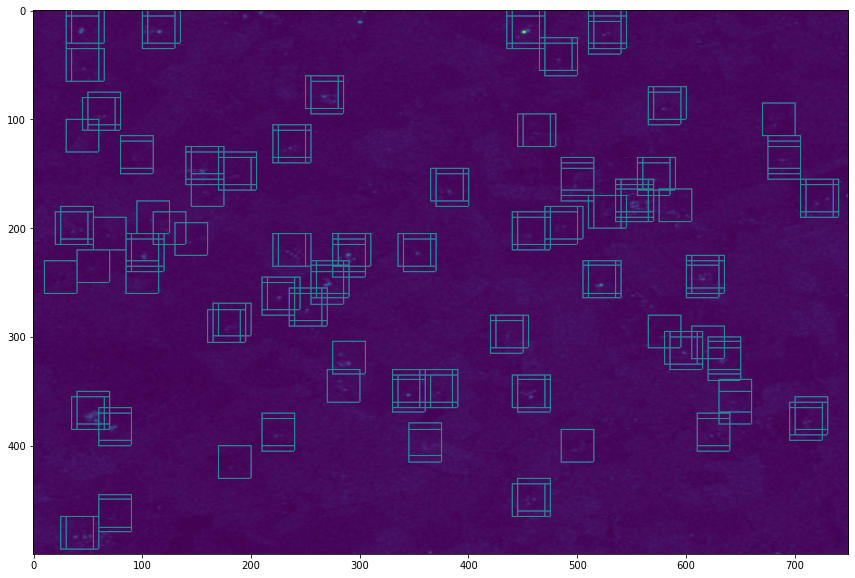

In [71]:
from matplotlib import pyplot as plt

search_space = np.copy(img_data[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
highlight = np.max(search_space)/2

found = 0
for i, result in enumerate(results):
    if result[1] > result[0]:
        found += 1
        coord = needles[i]
        xx, yy = dataset.index(coord['lon'], coord['lat'])
        xx -= left_top_x
        yy -= left_top_y

        search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
        search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
        search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
        search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight

print("found {} windmills".format(found))

plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(search_space)